NOTE: Some blocks in the report will be hidden because of confidentiality agreements.

__Author:__Jiahao Zhou    $\qquad$           __Student_ID__:2008817

This project was finished as a group work.
The ID number of group members are:

$\qquad\cdot$20***66 

$\qquad\cdot$20***17

$\qquad\cdot$20***59

$\qquad\cdot$20***66

## Project Overview:

$\bullet$ Use GARCH model to describe the volatility of return

$\bullet$ Derive the conditional cumulative distribution function of five assets

$\bullet$ Construct five dimensional Archimedean copula by distribution function

$\bullet$ Based on copula, use Monte Carlo Simulation method to simulate the returns and calculate ES

$\bullet$ Use a structured multi factor risk model to forecast returns

$\bullet$ Allocate weights based on optimization model (ES as restriction)

$\bullet$ Determine the number of shares according to the weight and do one hour trading

# 1.The preparation  for the project

## 1.1 Import all the necessay package for this trading alogrithm. 

In [1]:
!pip install ib_insync
!pip install arch
!pip install pynverse
!pip install pycopula
!pip install wheel
!pip install pyecharts==0.1.9.4
!pip install pyautogui

In [2]:
import numpy as np
import pandas as pd
import warnings
import random
import math
import ib_insync
from arch import arch_model
from scipy.stats import norm
from scipy.optimize import minimize
from pynverse import inversefunc
import matplotlib.pyplot as plt
from pycopula.copula import ArchimedeanCopula
from pyecharts import Line
import statsmodels.api as sm
from numba import jit
import time
import pyautogui
import win32api
import os
warnings.filterwarnings('ignore')

In [3]:
os.system("taskkill /F /IM tws.exe")
time.sleep(3)
win32api.ShellExecute(0, 'open', 'C:\\Jts\\tws.exe', '', '', 0)
time.sleep(40)
pyautogui.keyDown('alt')
pyautogui.press(['esc'])
pyautogui.keyUp('alt')
time.sleep(1)
pyautogui.press(['shift'])
pyautogui.typewrite('danye1602', interval=0.25)
pyautogui.press(['tab'])
pyautogui.typewrite('Hdy223935569', interval=0.25)
pyautogui.press(['enter'])
time.sleep(60)
pyautogui.press(['enter'])
time.sleep(1)
pyautogui.press(['space'])
time.sleep(3)
pyautogui.press(['enter'])
time.sleep(1)
pyautogui.press(['space'])
time.sleep(10)

## 1.2 Connect the IB TWS platform 

Using 2058852 ' IB account to get the data of five assets of each member.

In [4]:
stock_list = ['NEE','SO','AEP','EIX','FTS']    #Should be completed in alphabetical order
port = 8817    #Last four digits of student ID number
clientId = 2008817    #student ID numeber
simulation_times = 1000
ib = ib_insync.IB()
ib_insync.util.startLoop()
ib.connect('127.0.0.1', 8852, clientId=20588524)

<IB connected to 127.0.0.1:8852 clientId=20588524>

## 1.3 Request historical data from TWS. (last 200 days, interval =1 hour)

In [5]:
contract1 = ib_insync.Stock(stock_list[0], 'SMART', 'USD')
contract2 = ib_insync.Stock(stock_list[1], 'SMART', 'USD')
contract3 = ib_insync.Stock(stock_list[2], 'SMART', 'USD')
contract4 = ib_insync.Stock(stock_list[3], 'SMART', 'USD')
contract5 = ib_insync.Stock(stock_list[4], 'SMART', 'USD')
contract6 = ib_insync.Index('NYA', 'PSE', 'USD')

stock_1 = ib.reqHistoricalData(contract1,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
stock_2 = ib.reqHistoricalData(contract2,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
stock_3 = ib.reqHistoricalData(contract3,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
stock_4 = ib.reqHistoricalData(contract4,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
stock_5 = ib.reqHistoricalData(contract5,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
Msci = ib.reqHistoricalData(contract6,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)


In [6]:
df1 = ib_insync.util.df(stock_1).set_index('date')
df2 = ib_insync.util.df(stock_2).set_index('date')
df3 = ib_insync.util.df(stock_3).set_index('date')
df4 = ib_insync.util.df(stock_4).set_index('date')
df5 = ib_insync.util.df(stock_5).set_index('date')
df6 = ib_insync.util.df(Msci).set_index('date')

stocks = [df1, df2, df3, df4, df5]
time_list = stocks[0].index
data_need = ['close', 'open', 'high', 'low', 'volume', 'average']

In [7]:
#Connect our own account to trade
#Disconnect to the current TWS API
ib.disconnect()

#Open TWS
os.system("taskkill /F /IM tws.exe")
time.sleep(3)
win32api.ShellExecute(0, 'open', 'C:\\Jts\\tws.exe', '', '', 0)
time.sleep(40)
# pyautogui.keyDown('alt')
# pyautogui.press(['esc'])
# pyautogui.keyUp('alt')
time.sleep(1)
pyautogui.press(['shift'])
pyautogui.typewrite('jzhou0449', interval=0.25)
pyautogui.press(['tab'])
pyautogui.typewrite('zhou38209539', interval=0.25)
pyautogui.press(['enter'])
time.sleep(60)
pyautogui.press(['enter'])
time.sleep(1)
pyautogui.press(['space'])
time.sleep(3)
pyautogui.press(['enter'])
time.sleep(1)
pyautogui.press(['space'])
time.sleep(10)

In [8]:
#Connect to the new TWS API
ib_insync.util.startLoop()
ib.connect('127.0.0.1', port, clientId)

<IB connected to 127.0.0.1:8817 clientId=2008817>

## 2.Data process

We choose to compute return in this way:
$$r_i = \frac{(p_t)_i - (p_{t-1})_i}{(p_{t-1})_i},\qquad i=1,2,3,4,5$$ 

In [9]:
def getdataready(x):
    standard_df = pd.DataFrame(index = time_list, columns = stock_list)
    for i in range(5):
        standard_df[stock_list[i]] = stocks[i][x]
    return standard_df.T.sort_index(axis=0, by=None, ascending=True)


In [10]:
standard_df1 = pd.DataFrame(index = time_list, columns = ['NYA'])
standard_df1['NYA'] = df6['close']
Benchmark = standard_df1.T
Close = getdataready(data_need[0]) #get close price
Open = getdataready(data_need[1]) #get open price
High = getdataready(data_need[2]) #get highest price
Low = getdataready(data_need[3]) #get lowest price
Volume = getdataready(data_need[4]) #get volume
Average = getdataready(data_need[5]) # get average price
Return = (Close - Close.shift(1,axis = 1)) / Close.shift(1,axis = 1)
Return_benchmark = (Benchmark - Benchmark.shift(1,axis = 1)) / Benchmark.shift(1,axis = 1)
del df1, df2, df3, df4, df5, stock_1, stock_2, stock_3, stock_4, stock_5, standard_df1, Benchmark


Fundamental data of 5 assests(from Sina Finance):

In [11]:
capital_stock_data = [4.94, 3.59, 4.63, 4.76,  10.49] 
EPS_data = [1.49, 1.36, 0.48, 1.99, 1.26]
TA_data = [739.01, 642.12, 398.79, 1176.91, 1175.91]
TL_data = [537.65, 448.59, 255.54, 758.44, 855.09]
TE_data = [200.65, 153.53, 143.25, 418.47, 320.82]
longtermL_data = [256.09, 176.9, 173.44, 375.43, 436.99]
net_profit_data = [7.34, 4.71, 2.23, 9.75,  13.2]
fundamental = [capital_stock_data, EPS_data, TA_data, TL_data, TE_data, longtermL_data, net_profit_data]

In [12]:
#get fundamental data ready
def getfundamental_df(x):
    fundamental_df = pd.DataFrame(index = time_list, columns = stock_list)
    for i in range(5):
        fundamental_df[stock_list[i]] = fundamental[x][i]
    return fundamental_df.T.sort_index(axis=0, by=None, ascending=True)

Capital_stock = getfundamental_df(0)
EPS = getfundamental_df(1)
TA = getfundamental_df(2)
TL = getfundamental_df(3)
TE = getfundamental_df(4)
LongtermL = getfundamental_df(5)
Net_profit = getfundamental_df(6)

In [13]:
#calculate ratio: market_value, LNCAP, EPIBS, ETOP, BTOP, MLEV, DTOA 
Market_value = np.multiply(Close,Capital_stock)
LNCAP = np.log(Market_value) 
EPIBS = np.divide(EPS,Close)
ETOP = np.divide(Net_profit,Market_value)
BTOP = np.divide(TE,Market_value)
MLEV = np.divide(np.add(Market_value,LongtermL),Market_value)
DTOA = np.divide(TL,TA)

In [14]:
#Calculate assets' return
data = Return.T.dropna()#.reset_index(drop = True)
del capital_stock_data, EPS_data, TA_data, TL_data, TE_data, longtermL_data, net_profit_data

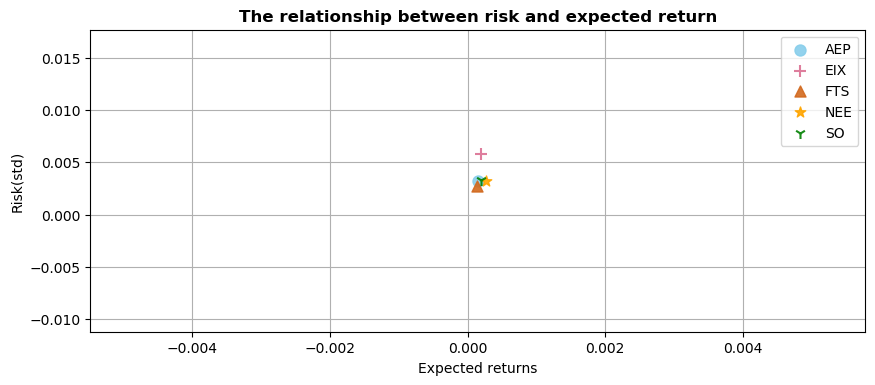

In [15]:
plt.figure(figsize = (10,4),dpi = 100)
area = np.pi*20
colors = ['#87CEEB','#DB7093','#D2691E','orange','green']
c_marker = ['o','+','^','*','1']
for i in range(5):
    plt.scatter(data.mean()[i], data.std()[i],c = colors[i],marker = c_marker[i],alpha = 0.9,label = data.columns[i],s =area)

plt.xlabel('Expected returns')
plt.ylabel('Risk(std)')
plt.grid(True)
plt.legend(loc = 'best')
plt.title("The relationship between risk and expected return", weight='bold')
plt.show()

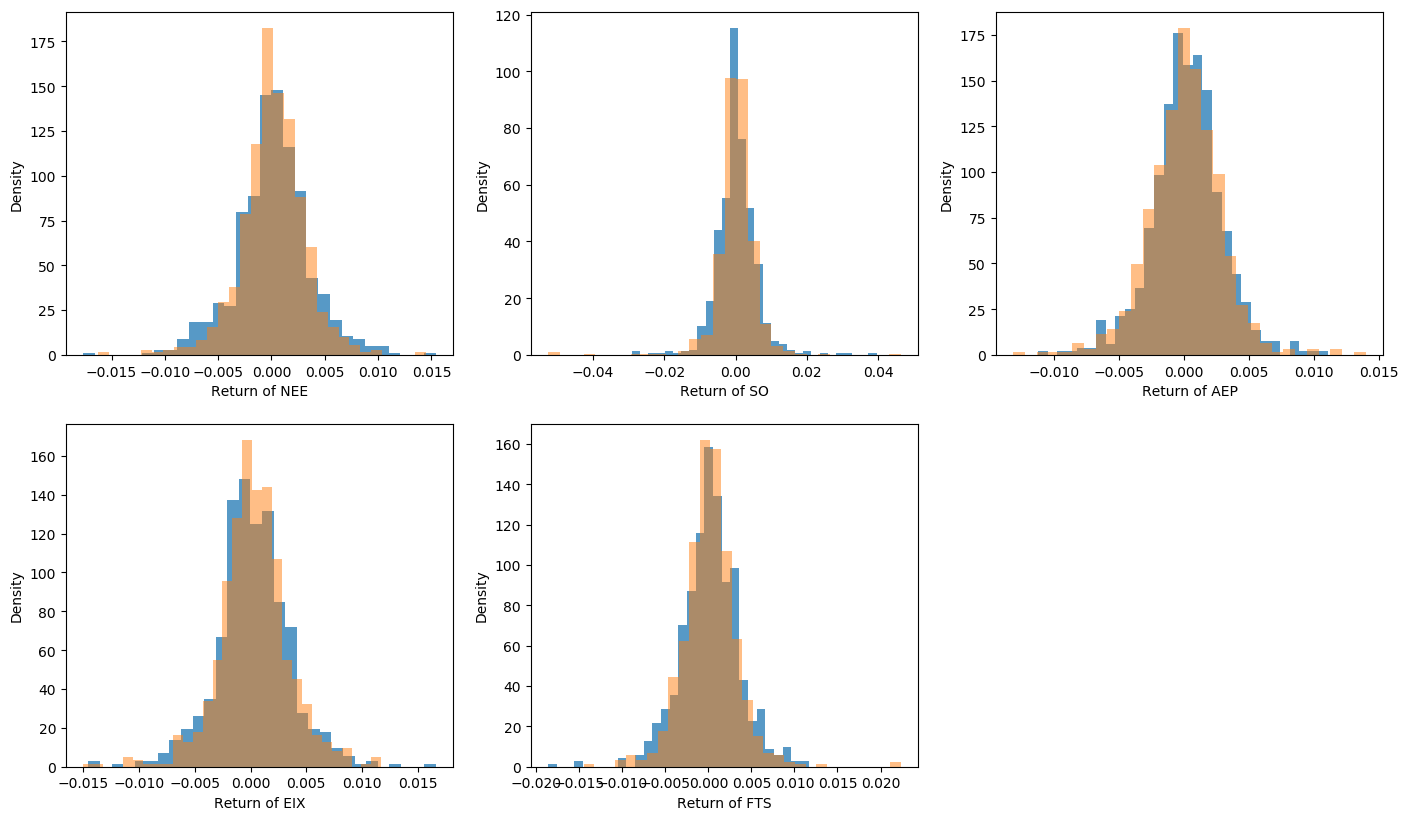

In [16]:
plt.close()
a = data.shape[0]
plt.figure(figsize = (17,10),dpi = 100)
for i in range(5):
    a1=data.iloc[:a//2,i]
    a2=data.iloc[a//2+1:,i]
    plt.subplot(2,3,i+1)
    plt.hist(a1,bins=30,density = 1,alpha = 0.75)
    plt.hist(a2,bins=30,density = 1,alpha = 0.5)
    plt.xlabel('Return of '+ stock_list[i])
    plt.ylabel('Density')
plt.show()

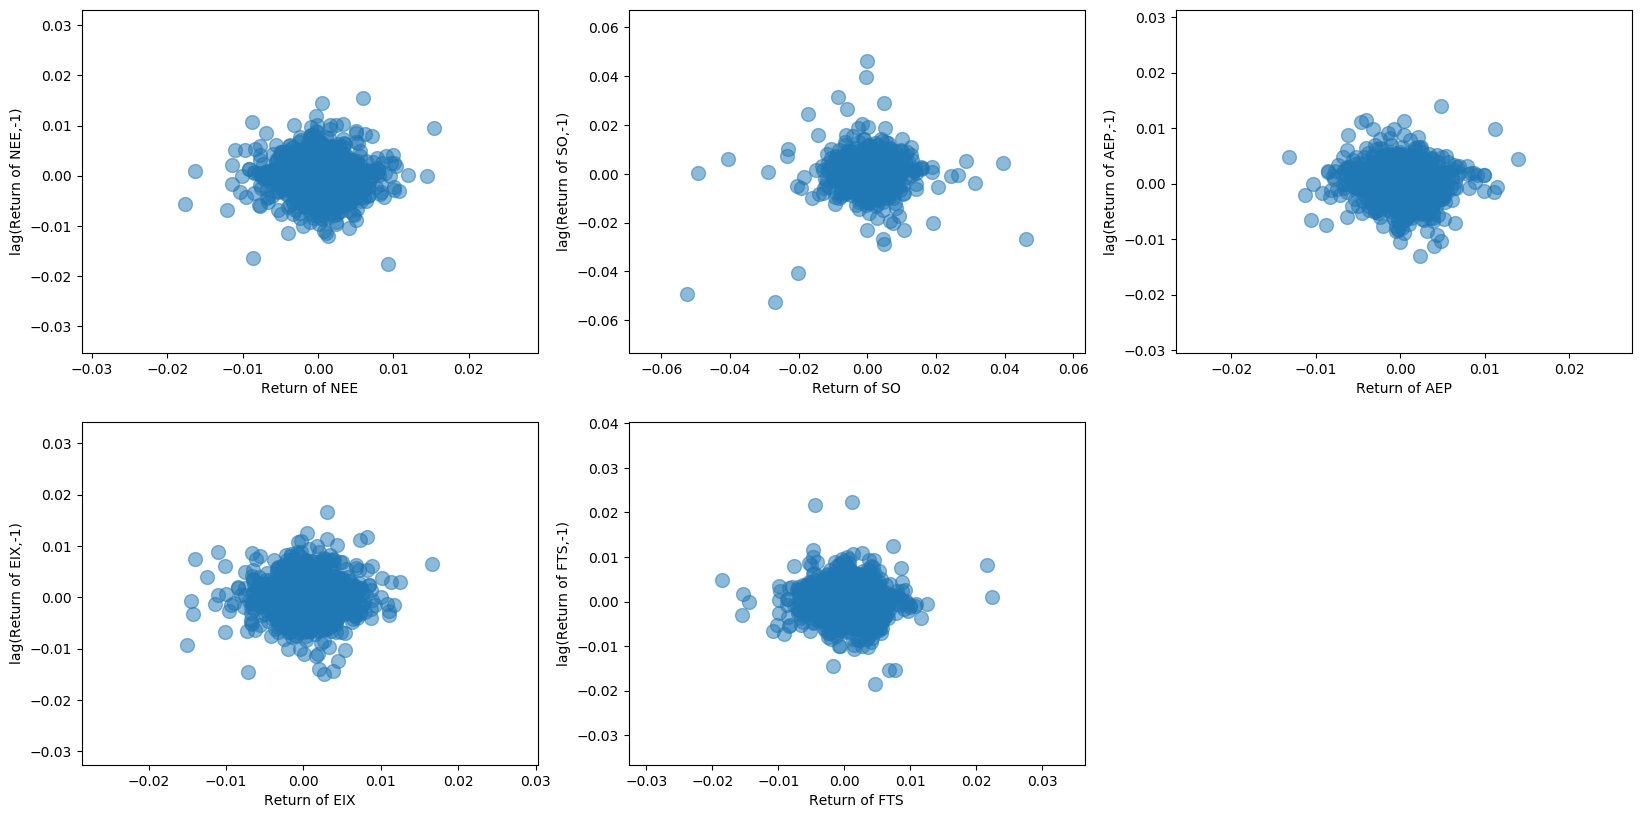

In [17]:
plt.close()
plt.figure(figsize=(20,10),dpi=100)
for i in range(5):
    x_scatter = pd.DataFrame(data.iloc[:,i])
    y_scatter = x_scatter.shift(1)
    plt.subplot(2,3,i+1)
    plt.scatter(x_scatter,y_scatter, s=100,alpha=0.5)
    plt.xlabel('Return of ' + stock_list[i])
    plt.ylabel('lag(Return of '+ stock_list[i] + ',-1)')
plt.show()

In a true random walk, any function of the increment must display close to zero auticorrelation(approximately an invariant). However,a closer empirical inspection reveals that some risk drivers display volatility clustering. [(ARPM Lab, Volatility clustering)](https://www.arpm.co/lab/volatility-clustering-invariants.html)

Thus to model the volatility clustering features, we consider GARCH(1,1) processes.

# 3.Compute Copula based on CDF of 5 assets

## 3.1 Use Garch(1,1) model to find the CDF of each return.

The Garch (1,1) module:

$$
\left\{
\begin{aligned}
r_t &= \mu+a_t \\
a_t &= \sigma _t \varepsilon_t, \qquad \varepsilon_t \sim N(0,1)\\
\sigma^2_t &= \alpha_0 + \alpha_1 a^2_{t-1}+\beta \sigma^2_{t-1} \\
\end{aligned}
\right.
$$

Then, we can get the conditional CDF of each stock based on the Garch(1,1) module:

$$
\begin{aligned}
P\{r_{t+1}|\Omega_t\} &= P\{a_{t+1} \leqslant (r-\mu)|\Omega_t\}\\
&= P\{ \sigma _{t+1} \varepsilon_{t+1} \leqslant (r-\mu)|\Omega_t\}\\ 
&= P\{\varepsilon_{t+1} \leqslant \frac{r-\mu}{\sqrt{\alpha_0 + \alpha_1 a^2_{t}+\beta \sigma^2_{t}}}\},\qquad \varepsilon_t \sim N(0,1)
\end{aligned}
$$

Hence, we can get the CDF of each stock. 

## 3.2 Calculate the value of the Garch(1,1) model parameters.

In [18]:
def get_arch_params(data_temp):
    am = arch_model(data_temp)
    model = am.fit(update_freq = 0)
    mu  = model.params[0]
    omega = model.params[1]
    alpha = model.params[2]
    beta = model.params[3]
    return [mu, omega, alpha, beta]

In [19]:
garch_params =[]
a_t = []
c_t = []
for i in range(5):
    data_ready = data.iloc[:,i]
    garch_params.append(get_arch_params(data_ready))
    a_t.append(data_ready.to_list()[-1]) 
    c_t.append(data_ready.var()) 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6007.594566947521
            Iterations: 5
            Function evaluations: 60
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -5295.083602886398
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6211.025922299303
            Iterations: 2
            Function evaluations: 32
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5998.873952083404
            Iterations: 4
            Function evaluations: 46
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5967.785105611146
            Iterations: 6
            Functio

D:\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [20]:
garch_params_df = pd.DataFrame(garch_params,index = Return.index,columns = ['mu','alpha_0','alpha_1','beta'])
garch_params_df

,mu,alpha_0,alpha_1,beta
AEP,0.000163,0.000001,0.050000,0.850000
EIX,0.000173,0.000003,0.050000,0.850000
FTS,0.000122,0.000004,0.050000,0.450000
NEE,0.000283,0.000005,0.100000,0.400000
SO,0.000190,0.000005,0.050003,0.449999


## 3.3 Using Clayton copula to find Joint Cumulative Distribution Function

The expression of Clayton copula is:
$$
C(\mu_1,\mu_2,\mu_3,\mu_4,\mu_5) = [\sum ^{5}_{i=1} \mu_i^{-\theta}-5+1]^{-\frac{1}{\theta}},\qquad \theta>0 
$$

In [21]:
archimedean = ArchimedeanCopula(family="clayton", dim=5)
theta = archimedean.fit(data.values, method="cmle",verbose = True)[0]
print('Archimedes copula parameter theta is',theta)

Archimedes copula parameter theta is 0.6412421038007052


# 4.Estimate Expected Shortfall(CVaR) based on Monte Carlo Simulation

## 4.1 Monte Carlo Simulation

After all parameters of the copula $C(u_1, u_2, u_3, u_4, u_5)$ are known, we use the method of conditional distributions to generate series of variables. 

Firstly, let $C_{u_1}$ denotes the conditional distribution function for the random variable $u_2$ at a given value $u_1$ of the two-dimensional copula $C(u_1, u_2)$, with the following expression: 
$$C_{u_1}(u_2)=\frac{\partial C(u_1, u_2)}{\partial u_1}$$ 
In addition, $C_{u_1}$ are non-decreasing almost everywhere on $[0,1]$. Similarly, the function: 
$$u_2 \rightarrow C_{u_1}(u_2)=\frac {\partial C(u_1, u_2)}{\partial u_1}$$
is also uniformly distributed on $[0,1]$.

Therefore, in general, for k-dimension copula $C(u_1, u_2, ..., u_k)$, the k-1 steps conditional distribution function:
$$u_k \rightarrow C_{u_1 u_2...u_{k-1}}(u_k)=\frac {\partial C(u_1, u_2, ..., u_k)} { \partial u_1 \partial u_2 \partial u_{k-1}}$$
is uniformly distributed on $[0,1]$.

Secondly, in order to generate random numbers, we need the following theorem[[2]](https://ebookcentral.proquest.com/lib/bham/reader.action?docID=219703):

Let $C(u_1, u_2, ..., u_k) = \varphi^{-1}(\varphi(u_1)+\varphi(u_2)+...+\varphi(u_k))$ be an Archimedean n-variate copula with generator $\varphi(\cdot)$,

\begin{equation}
\begin{aligned}
C_k(u_k|u_1,...,u_{k-1}) = \frac{\varphi^{-1 (k-1)}(\varphi(u_1)+\varphi(u_2)+...+\varphi(u_k))}{\varphi^{-1 (k-1)} (\varphi(u_1)+\varphi(u_2)+...+\varphi(u_{k-1}))},\qquad k=2,3,...,n 
\end{aligned}
\end{equation}

In following process, we should declare:

\begin{equation}
\begin{aligned}
\varphi ^{-1 (k)}(t) = (-1)^k \frac{(\theta+1)(\theta+2).....(\theta+k-1)}{\theta^k}(t+1)^{-\frac{1}{\theta}-k}
\end{aligned}
\end{equation}

The following algorithm generates a random variate $(u_1, u_2,.., u_5)'$ from Clayton copula:

$\qquad \cdot$ Simulate n independent random variables $(v_1, v_2,.., v_5)'$ from $U(0,1)$

$\qquad \cdot$ Set $u_1 = v_1$

$\qquad \cdot$ Set $v_2 = C_2(u_2|v_1)$ Hence, we get that:

\begin{equation}
\begin{aligned}
v_2 &= \frac{\varphi ^{-1 (1)}(c_2)}{\varphi ^{-1 (1)}(c_1)} = \left ( \frac{u_1^{- \theta} + u_2^{- \theta} - 1}{u_{1}^{-\theta}} \right )^{-\frac{1}{\theta}-1}
\end{aligned}
\end{equation}

So
\begin{equation}
\begin{aligned}
u_2 = \left ( v_1^{- \theta} ( v_2^{- \frac{\theta}{\theta + 1}} - 1 ) + 1 \right )^{-\frac{1}{\theta}}
\end{aligned}
\end{equation} 


$\qquad \cdot$ Then
\begin{equation}
\begin{aligned}
v_3 = C_3(u_3|u_1, u_2)= \frac{\varphi ^{-1 (2)}(c_3)}{\varphi ^{-1 (2)}(c_2)}
\end{aligned}
\end{equation} 


......


$\qquad \cdot$ In general, solve in $u_n$ the equation
\begin{equation}
\begin{aligned}
v_n = \left ( \frac{u_1^{- \theta} + u_2^{- \theta} + ... + u_n^{- \theta} -n+1}{u_1^{- \theta} + u_2^{- \theta} + ... + u_{n-1}^{- \theta} -n+2} \right )^{-\frac{1}{\theta}-n+1}
\end{aligned}
\end{equation} 

$\qquad \cdot$ So we have
\begin{equation}
\begin{aligned}
u_n = \left \{ (u_1^{- \theta} + u_2^{- \theta} + ... + u_{n-1}^{- \theta} -n+2) \cdot \left ( v_n^{\frac{\theta}{\theta(1-n)-1}} \right ) +1 \right \}^{-\frac{1}{\theta}}
\end{aligned}
\end{equation} 

Now, we have generated random numbers for m groups $(u_1, u_2, u_3, u_4, u_5)^{m}$, where m is the number of Monte Carlo simulations.

Finally, we can use Quantile $F^{-1}(\cdot)$ to the get the simulated returns:
\begin{equation}
\begin{aligned}
r_i^{j} = F^{-1}(u_i^j) \quad \quad i = 1,2,...,5 ，\qquad j = 1,2,...,m
\end{aligned}
\end{equation}

In [22]:
#generate random numbers
v = [[],[],[],[],[]]
for i in range(5):
    for j in range(1000):
        x = random.uniform(0,1)
        v[i].append(x)

In [23]:
#estimate u
u = [[],[],[],[],[]]
u[0] = v[0]
#get theta from copula
for i in range(1000):
    x = ((v[0][i] ** (-theta)) * (v[1][i] ** (-theta / (1 + theta)) - 1) + 1) ** (- 1 / theta)
    u[1].append(x)

for i in range(1000):
    x = ((u[0][i] ** (-theta) + u[1][i] ** (-theta) - 3) * (v[2][i] ** (theta / (- 4 * theta - 1)) - 1) + 1) ** (-1/theta)
    u[2].append(x)

for i in range(1000):
    x = ((u[0][i] ** (-theta) + u[1][i] ** (-theta) + u[2][i] ** (-theta) - 3) * (v[3][i] ** (theta / (- 4 * theta - 1)) - 1) + 1) ** (-1/theta)
    u[3].append(x)

for i in range(1000):
    x = ((u[0][i] ** (-theta) + u[1][i] ** (-theta) + u[2][i] ** (-theta) + u[3][i] ** (-theta) - 3) * (v[4][i] ** (theta / (- 4 * theta - 1)) - 1) + 1) ** (-1/theta)
    u[4].append(x)
    

In [24]:
u_ppf = [[],[],[],[],[]]

for i in range(5):
    for j in range(1000):
        u_ppf[i].append(norm.ppf(u[i][j]))

## 4.2 Generate the estimated returns

In [25]:
r_simulation = [[],[],[],[],[]]
for i in range(5):
    function_r_adj = (lambda x : (x - garch_params[i][0])/((garch_params[i][1] + garch_params[i][2] * (a_t[i] ** 2) + garch_params[i][3] * (c_t[i] ** 2)) ** 0.5))
    inv_func_r_adj = inversefunc(function_r_adj)
    for j in range(1000):
        r_simulation[i].append(inv_func_r_adj(u_ppf[i][j]).tolist())

The stocks return after 1000 simulations is:

In [26]:
r_simulation_df = pd.DataFrame(r_simulation,index = Return.index)
r_simulation_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
AEP,0.001037,-0.000229,-0.000468,0.000172,0.001816,0.000358,0.000140,0.000114,0.000710,-0.000305,...,0.001248,-0.001095,-0.001919,0.000072,-0.000723,0.001225,-0.001704,0.000210,-0.000754,-0.001465
EIX,-0.000610,0.000981,-0.001434,0.000794,0.001027,0.002972,-0.000070,0.004274,0.001342,0.000626,...,0.001622,0.000091,-0.002234,0.000605,0.001336,-0.000948,-0.001517,0.001282,-0.001561,-0.000890
FTS,0.001367,0.003597,0.002003,2.618034,2.618034,2.618034,0.001494,2.618034,2.618034,0.002636,...,2.618034,-0.000959,0.001830,0.005629,0.002842,0.002116,-0.000205,2.618034,0.001281,-0.002011
NEE,0.002431,0.005977,0.000710,0.003930,0.003222,0.004616,0.001691,0.004495,0.004410,0.003665,...,2.618034,0.000426,-0.000775,0.001560,0.003081,0.004576,-0.000311,0.004259,-0.001745,-0.001617
SO,0.002203,0.000224,-0.002519,0.002643,0.006518,0.004499,-0.001356,0.000087,0.003570,0.000971,...,0.003159,0.000517,-0.001262,0.000920,-0.000103,-0.001103,0.000820,0.000757,-0.000647,-0.004288


## 4.3 Estimate ES(CVaR)

After Monte Carlo Simulation, we have got five-dimension rates of return, which represents random variables of each stocks in the future. Then we can calculate ES(CVaR) of each stock based on the definition of ES:

$\qquad\cdot$ Calculate 1% quantile of each stock

$\qquad\cdot$ Intercept the data before 1% quantile of each stock

$\qquad\cdot$ Calculate the mean of intercepted data as CVaR of each stock


In [27]:
VaR = []
CVaR = []
for i in range(5):
    r_sim_sorted = sorted(r_simulation[i])
    VaR.append(r_sim_sorted[math.floor((len(r_simulation[i])*(1 - 0.99)) - 1)])
    CVaR.append(np.mean(r_sim_sorted[:math.floor((len(r_simulation[i])*(1 - 0.99)) - 1)]))

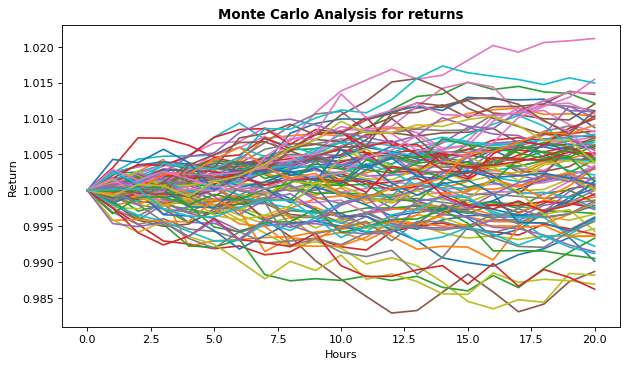

In [28]:
start_return = [1]
plt.figure(figsize=(9, 5),dpi = 80)
for i in range(2):
    for j in range(50):
        stock_m_c = start_return + list((r_simulation_df.iloc[i,20*j:20*(j+1)]+1).cumprod())
        plt.plot(stock_m_c,linewidth=1.5)
plt.xlabel("Hours")
plt.ylabel("Return")
plt.title('Monte Carlo Analysis for returns',weight='bold')
plt.show()

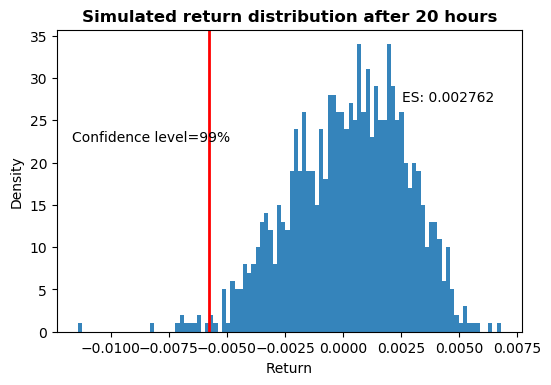

In [29]:
plt.figure(figsize = (6,4),dpi = 100)
a = list(r_simulation_df.iloc[0,:]+list(r_simulation_df.iloc[1,:]))
q = np.percentile(a, 1)
plt.hist(a,bins=100,alpha = 0.9)
plt.figtext(0.7, 0.7, s="ES: %.6f" %np.min(np.abs(CVaR)))
plt.figtext(0.15, 0.6, "Confidence level=99%")
plt.axvline(x=q, linewidth=2, color='r')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title("Simulated return distribution after %s hours" % 20, weight='bold')
plt.show()

# 5. Further analysis - Structured Multi Factor Risk Model

Actually, we can already  find the optimal weights through the steps above.However, since there are a great deal of factors will impact the price of stock,the price and return of a stock estimated from historical data might not be accurate in the future. 

Hence, our specific research idea is to build a structured multi factor model with a set of risk factors ($Beta$) and an $Alpha$ factor by using the validity test of risk factors of BARRA[[1]](http://www.alacra.com/alacra/help/barra_handbook_US.pdf) .

First of all, the simple linear decomposition of the return is carried out:
$$r_i = x_{i1} f_{i1} + x_{i2} f_{i2} + \cdots + x_{ik} f_{ik} + \alpha_i $$

$\bullet$$r_i$ is the return of stock $i$ <br>
$\bullet$$x_{ik}$ is the exposure of the stock $i$ to the $k$ factor (aka factor loading) <br>
$\bullet$$f_{ik}$ is the risk factor return of factor $k$ of stock $i$ <br>
$\bullet$$\alpha_i$ is the return of alpha factor of stock $i$

Then, we select risk factors and Alpha factors, and investigate the strength of these two factors. <br>
Finally, we get the weight of the optimal portfolio through the optimization model.

## 5.1 Risk Factors

We choose 8 major factors consisting of 12 adjoint factors to further assess investment risk:

|Major Factor |Adjoint Factor|                     Estimation Method                       |
|:-----------:|:------------:|:--------------------------------------------------------------------------------:|
|  $Beta$   |    BETA    |$r_i = \alpha + \beta r_m + e_i$, where $r_i$ is the yield series of stock i, $r_m$is the yield series of market      |               
| $Momentum$ |    RSTR    |$RSTR = \sum_{t=L}^{T+L} \omega_t [\ln{(1+r_t)}]$,  where $T=500$, $L=21$, <br>and yield series are all weighted by half-life index, with half-life of 120 days |
|  $Size$   |    LNCAP   |$LNCAP = \ln{(total \; market \; capitalization)}$               |
| $Earnings$<br>$Yieid$   |    EPIBS<br> ETOP |$EPIBS = \frac {EPS} {P}$, where $EPS$ is earning per share and $P$ is price of stock<br>$ETOP= \frac {net\; income} {maket \;value}$|
|$Volatility$| HSIGMA | $HSIGMA = std(e_i)$, where $e_i$ is the residual series from estimating $Beta$ |
|$Value$| BTOP | $BTOP=\frac {total\;equity} {total \; market \; capitalization}$ |
|$Leverage$|MLEV<br>DTOA | $MLEV=\frac{ME + LD} {ME}$, where $ME$ is current market value, and $LD$ is long-term debt<br> $DTOA = \frac {TD} {TA}$, where $TD$ is total debt, and $TA$ is total asset|
|   |STOM| $STOM = \ln{(\sum_{t=1}^T \frac {V_t}{S_t})}$, where $V_t$ is volumn, and $S_t$ is capital stock|
|$Liquidity$|STOQ|$STOQ = \ln{(\frac{1}{T} \sum_{t=1}^T exp(STOM_t) )}$, where $T=3$|
|   | STOA| $STOA = \ln{(\frac{1}{T} \sum_{t=1}^T exp(STOM_t) )}$, where $T=12$|


NOTE: Details of definitions of all risk factors are hidden here.

In [38]:
Beta,Volatility = get_beta_hsigma(Return,Return_benchmark)

Momentum = get_momentum(Return)

Size = getStyle_size(Market_value)

Value = getStyle_value(BTOP)

Leverage = get_leverage(LongtermL,Market_value,TL,TA)

Liquidity = get_liquidity(Volume,Capital_stock)

Earning_yield = get_earning_yield(Net_profit,Close,EPS)


## 5.2 Alpha Factors

According to the efficient market hypothesis, in a strongly effective securities market, the prices of each security have completely reflected all of information. Then, it is impossible to earn extra profits for all of trades which are based on diverse information including private and public information. 

However, the fact is that most of current markets is not strongly efficient(Malkiel, B.G, 2003)[[4]](http://www.bu.edu/econ/files/2011/01/Malkiel.pdf). Although investors can instantly  obtain various information through many ways, such as finacial report of each company, there still exist a great deal of hidden information that should be deeply excavated. If these hidden information are found by more and more market participants, the value of these hidden information will vanish and the whole market will become more and more effective. These hidden information is known as alpha factors.

Alpha factors are a set of variables that have a significant and stable impact on stock returns. At the same time, the effect is independent of all other factors' effects on returns. Currently, many formulaic alpha factors have been detected and their validities have been tested and proved by some quantitative traders. According to 101 Formulaic Alphas (Zura Kakushadze, 2015)[[3]](https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf), we choose four common and significant alpha factors to predict the future trend of price of securities, as following:

Fomula of alpha factors:


$\bullet$alpha 1
flag1 = Return<0
flag2 = Return>=0
temp1 = pd.DataFrame(index = Return.index,columns = Return.columns)
temp1\[flag1\] = STD(Return,20,16)
temp1\[flag2\] =Close
alpha_1 =  RANK(TSARGMAX(SIGNEDPOW(temp1,2.),5,4))-0.5

$\bullet$alpha_2 = -1 * CORR(RANK(DELTA(LOG(Volume), 2)), RANK(((Close - Open) / Open)), 6,5)

$\bullet$alpha_3=RANK(((1 - RANK((STD(Return, 2,2) / STD(Return, 5,4)))) + (1 - RANK(DELTA(Close, 1)))))

$\bullet$alpha_4=(((((2.21 * RANK(CORR((Close - Open), DELAY(Volume, 1), 15,13))) + (0.7 * RANK((Open - Close)))) + (0.73 * RANK(TSRANK(DELAY((-1 * Return), 6), 5,4)))) + RANK(np.abs(CORR(Average, ADV(20,16), 6,5)))) + (0.6 * RANK((((MEAN(Close, 200,180)) - Open) * (Close - Open)))))

NOTE: Definitions of Alpha Factors are hidden here.

In [41]:
Predict_period = 1
Multifactor_window = 250
Iter_period = 500
risk_factors = [Beta, Momentum, Size, Earning_yield, Value, Volatility, Liquidity, Leverage]
risk_factor_list = ['beta','momentum','size','earning_yield','value','volatility','liquidity','leverage']
alphas = [alpha1,alpha2]
# alphas = [alpha1,alpha2,alpha3,alpha4,alpha5]
alpha_list = [1,2]
# alpha_list = [1,2,3,4,5]
residual_list_store = []
strongest_alpha_number = alpha_list

# 6.Construct Structured Multi Factor Risk Model

## 6.1 Weighted Least Squares

We now have already selected a few valuable factors based on risk factors and alpha factors. Then, we need to build multiple-factor risk model to predict the future trend of return of each stock. In general, we can fit those chosen factors and estimate parameters of them through the method of Ordinary Least Squares (OLS). Nevertheless, in accordance to empirical analysis(Zura Kakushadze，2015)[[3]](https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf), there are significant correlations among these factors. Building a regression model based on the method of Ordinary Least Squares (OLS) would loss a part of information and lead to inaccurate predicted outcomes . 

To further extract information of residual series of regression model, we use Weighted Least Squares (WLS) to estimate each parameter and fit model. In addition, we add dummy variables so that we can find the influence from different industries. The model is as follows:

$$R = X \beta + e, E(e) = 0, var(e) = \sigma^2 \Sigma, Cov(e,x) = 0$$ 

Where, $X$ is a set of factors; $R$ is rate of return series. We can get:

$$\beta = (X^T \Sigma^{-1}X)^{-1}X^T \Sigma^{-1}R$$

Through the structured multi factor risk model, the future return is predicted. Now, we can put them into the optimization model to get the best portfolio weight.

NOTE: Code of Multi Factor Risk Model are hidden here because of confidentiality agreements.

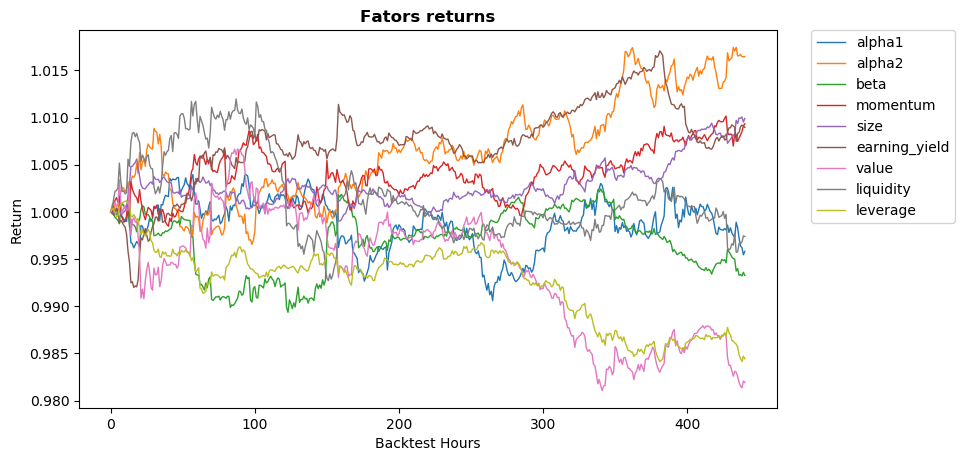

In [44]:
start_return = [1]
plt.figure(figsize=(9, 5),dpi = 100)
xx = coef_all_df.drop([7])
labels = ['alpha1','alpha2','beta','momentum','size','earning_yield','value','liquidity','leverage']
for i in range(len(xx.index)):
    stock_m_c = start_return + list((xx.iloc[i,700:]+1).cumprod())
    plt.plot(stock_m_c,linewidth=1,label = labels[i])
plt.xlabel("Backtest Hours")
plt.ylabel("Return")
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0)
plt.title('Fators returns',weight='bold')
plt.show()

# 7. Find the optimal weights of a portfolio

In order to find optimal weight of each stock in a portfolio, we can build a optimization system:

$$
Max \sum_{i=1}^{5} \omega_{i} \hat{r_i}-r_{benchmark}\\
\begin{aligned}
s.t. CVaR(\sum_{i=1}^{5} \omega_{i} r_i) &\leqslant 1\% \\
\sum_{i=1}^{5} \omega_{i} &= 1
\end{aligned}
$$

However, it is difficult to estimate CVaR of a portfolio. Therefore, according to the subadditivity and homogeneity of CVaR, we can transfer the first constraint condition to :
$$
\begin{aligned}
CVaR(\sum_{i=1}^{5} \omega_{i} r_i) &\leqslant \sum_{i=1}^{5} CVaR(\omega_{i} r_i)\\
&= \sum_{i=1}^{5} \omega_{i} CVaR( r_i)
\end{aligned}
$$

Now we obtain a new linear optimization system which can be simply solved. :
$$
Max \sum_{i=1}^{5} \omega_{i} \hat{r_i}-r_{benchmark}\\
\begin{aligned}
s.t. \sum_{i=1}^{5} \omega_{i} CVaR( r_i) &\leqslant 1\% \\
\sum_{i=1}^{5} \omega_{i} &= 1
\end{aligned}
$$



In [45]:
#calculate estimated return
global coef_all_df    
temp = alphas + risk_factors
r_predict = []
for j in range(5):
    r_predict_singlestock = 0
    for i in range(len(temp)):
        r_predict_singlestock += list(coef_all_df.iloc[:,-1])[i] * temp[i].iloc[:,-1][j]
    r_predict.append(r_predict_singlestock)
for i in range(5):
    if np.isnan(r_predict[i]):
        r_predict[i] = 0
    
#calculate optimal weights
e = 1e-10 
fun = lambda x : -(x[0] * r_predict[0] + x[1] * r_predict[1] + x[2] * r_predict[2] + x[3] * r_predict[3] + x[4] * r_predict[4])# constraints
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] + x[3] + x[4] - 1}, 
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, 
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e},
        {'type': 'ineq', 'fun': lambda x: x[3] - e},
        {'type': 'ineq', 'fun': lambda x: x[4] - e},
        {'type': 'ineq', 'fun': lambda x: 0.01 + x[0] * CVaR[0] + x[1] * CVaR[1] + x[2] * CVaR[2] + x[3] * CVaR[3] + x[4] * CVaR[4] - e})
    
x0 = np.array((0.2, 0.2, 0.2, 0.2, 0.2)) 
res = minimize(fun, x0, method='SLSQP', constraints=cons)
Relative_Return = - res.fun - Return_benchmark.iloc[0,-1]
weights = res.x
show = pd.DataFrame(weights,columns =['weights'] ,index = Return.index)
show

,weights
AEP,1.000004e-10
EIX,9.999990e-11
FTS,1.000002e-10
NEE,1.000000e+00
SO,1.000005e-10


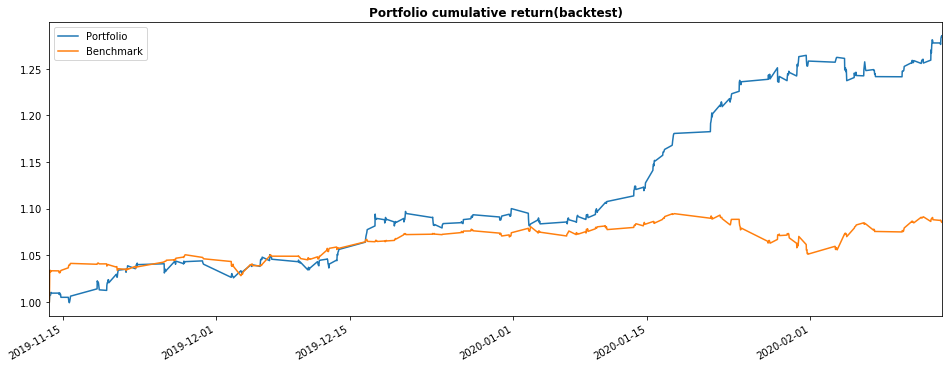

Relative_Return: 0.1986071419612787


In [46]:
temp = alphas + risk_factors
bt_return = []
for k in range(700,len(coef_all_df.columns)):
    r_predict_backtest = []
    for j in range(5):
        r_predict_singlestock = 0
        for i in range(len(temp)):
            r_predict_singlestock += list(coef_all_df.iloc[:,k-1])[i] * temp[i].iloc[:,k-2][j]
        r_predict_backtest.append(r_predict_singlestock)
    bt_return.append(r_predict_backtest)

tt = []
for yy in bt_return:
    e = 1e-10 
    fun = lambda x : -(x[0] * yy[0] + x[1] * yy[1] + x[2] * yy[2] + x[3] * yy[3] + x[4] * yy[4])# 约束函数
    cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] + x[3] + x[4] - 1}, 
            {'type': 'ineq', 'fun': lambda x: x[0] - e}, 
            {'type': 'ineq', 'fun': lambda x: x[1] - e},
            {'type': 'ineq', 'fun': lambda x: x[2] - e},
            {'type': 'ineq', 'fun': lambda x: x[3] - e},
            {'type': 'ineq', 'fun': lambda x: x[4] - e},
            {'type': 'ineq', 'fun': lambda x: 0.003 + x[0] * CVaR[0] + x[1] * CVaR[1] + x[2] * CVaR[2] + x[3] * CVaR[3] + x[4] * CVaR[4] - e})

    x0 = np.array((0.2, 0.2, 0.2, 0.2, 0.2)) 
    res = minimize(fun, x0, method='SLSQP', constraints=cons)
    tt.append(-res.fun)

backtest = (pd.DataFrame(tt,index = (coef_all_df.iloc[:,700:]).columns,columns = ['Portfolio_return']).fillna(0)+1).cumprod()
backtest_ready = pd.concat([backtest,(Return_benchmark.T+1).cumprod()], axis = 1).dropna()
backtest_ready.iloc[0:1,:] = 1

plt.figure(figsize=(16,6))
backtest_ready['Portfolio_return'].plot()
backtest_ready['NYA'].plot()
plt.legend(['Portfolio','Benchmark'],loc='upper left')
plt.title('Portfolio cumulative return(backtest)',weight='bold')
plt.show()
print('Relative_Return:',backtest_ready.iloc[-1,0]-backtest_ready.iloc[-1,1])

In [47]:
def max_drawdown(x):
        count=len(x.index)
        max_DD_list = np.zeros(count)
        for i in range(1,count-1):
            max_DD_list[i] = (x[i] - x[i:count-1].min())/x[i]
        max_DD = max(max_DD_list)
        return max_DD

result_backtest = pd.DataFrame(columns =['Backtesting start point','Backtesting end point','cumulative return','Volatility','Maximum drawdown','Sharpe Ratio','Win rate'] ,index = ['Portfolio','Benchmark'])
result_backtest.iloc[0:2,0] = backtest_ready.index[0]
result_backtest.iloc[0:2,1] = backtest_ready.index[-1]
result_backtest.iloc[0,2] = backtest_ready.iloc[-1,0]-1
result_backtest.iloc[1,2] = backtest_ready.iloc[-1,1]-1
result_backtest.iloc[1,2] = backtest_ready.iloc[-1,1]-1
zz = pd.DataFrame(tt,index = (coef_all_df.iloc[:,700:]).columns,columns = ['Portfolio_return']).fillna(0)
zz_temp =  pd.concat([zz,Return_benchmark.T],axis = 1).dropna()
result_backtest.iloc[0,3] = zz_temp.std()[0]
result_backtest.iloc[1,3] = zz_temp.std()[1]
result_backtest.iloc[0,4] = -max_drawdown(backtest_ready.iloc[:,0])
result_backtest.iloc[1,4] = -max_drawdown(backtest_ready.iloc[:,1])
result_backtest.iloc[:,5] = result_backtest.iloc[:,2]/(result_backtest.iloc[:,3])**0.5
result_backtest.iloc[0,6] = sum(zz_temp['Portfolio_return']>zz_temp['NYA'])/len(zz_temp.index)
result_backtest.iloc[1,6] = 0
result_backtest

,Backtesting start point,Backtesting end point,cumulative return,Volatility,Maximum drawdown,Sharpe Ratio,Win rate
Portfolio,2019-11-13 15:00:00,2020-02-14 19:00:00,0.284226,0.00304769,-0.0215244,5.14847,0.554545
Benchmark,2019-11-13 15:00:00,2020-02-14 19:00:00,0.0856191,0.00214786,-0.0396258,1.84743,0


Win rate means the probability that the portfolio single-hour return is greater than the benchmark

# 8. Do the trade

In [48]:
#get the balance of account
#account_value = [v for v in ib.accountValues() if v.tag == 'NetLiquidationByCurrency' and v.currency == 'BASE']
#balance =account_value[0][2]
balance = 900000.0

#get the lastest price of each stock
last_prices = []
for i in range(5):
    last_prices.append(stocks[i]["close"][-1])

#compute the number of shares
position = []
for i in range(5):
    position.append(int(weights[i]*balance/last_prices[i]))

#buy at market price
order = []
for i in range(5):
    order.append(ib_insync.MarketOrder("BUY", position[i]))

contract = [contract1, contract2, contract3, contract4, contract5]
for i in range(5):
    if (position[i]!= 0):
        trade = ib.placeOrder(contract[i], order[i])


print("Start trading time:", time.ctime())
account_value_start = [v for v in ib.accountValues() if v.tag == 'NetLiquidationByCurrency' and v.currency == 'BASE']
balance_start = float(account_value_start[0][2])

ib.sleep(3000)    

#sell at market price
order = []
for i in range(5):
    order.append(ib_insync.MarketOrder("SELL", position[i]))

for i in range(5):
    if (position[i]!= 0): 
        trade = ib.placeOrder(contract[i], order[i])


print("Trading close time:", time.ctime())
account_value_end = [v for v in ib.accountValues() if v.tag == 'NetLiquidationByCurrency' and v.currency == 'BASE']
balance_end = float(account_value_end[0][2])

#print return of 1 hours trading
result_realtrade = pd.DataFrame(columns =['balance','return'] ,index = ['Before Trading','After Trading'])
result_realtrade.iloc[0,0] = balance_start
result_realtrade.iloc[1,0] = balance_end
result_realtrade.iloc[0,1] = 0
result_realtrade.iloc[1,1] = (balance_end-balance_start)/balance_end

Start trading time: Mon Feb 17 21:00:23 2020
Trading close time: Mon Feb 17 21:00:53 2020


# 9. Referrence

[[1]](http://www.alacra.com/alacra/help/barra_handbook_US.pdf) Barra. (1998) 'United States Equity', in Risk Model Handbook. Version 3 (E3), pp.74-75.

[[2]](https://ebookcentral.proquest.com/lib/bham/reader.action?docID=219703) Cherubini, U., Luciano, E. and Vecchiato, W. (2004) Copula methods in finance, Hoboken: Wiley, pp. 181-185

[[3]](https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf) Kakushadze, Z (2016) '101 Formulaic Alphas ', Wilmott, 2016(84), pp. 72-81.

[[4]](http://www.bu.edu/econ/files/2011/01/Malkiel.pdf) Malkiel, B.G (2003) 'The efficient market hypothesis and its critics', Journal of Economic Perspectives, 17(1), pp. 59-82.
